In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np

xl_file = pd.ExcelFile("./data/instances.xlsx")

graphs = []
edges = []
sizes = []
for sheet_name in xl_file.sheet_names:
    df = xl_file.parse(sheet_name, header=None)
    size = df.iloc[0,1]
    sizes.append(size)
    edge = df.iloc[4:].to_numpy()[:,1:]
    edges.append(edge)
    graph = np.zeros((size,size))
    for i in range(len(edge)):
        graph[edge[i][0], edge[i][1]] = edge[i][2]
    graphs.append(graph)

# dfs = [xl_file.parse(sheet_name, header=None) for sheet_name in xl_file.sheet_names]


In [ ]:
import time
t0 = time.time()
idx = 0
c = graphs[idx]
cmax = np.max(c)
n = sizes[idx]
A = edges[idx][:,:2].astype(int)
N = np.arange(n)
ign_node = 0

m1 = gp.Model('Fire_STP')
m2 = gp.Model('Fire_STP_Dual')


x = m1.addMVar((n,n),vtype=GRB.INTEGER, name="x", lb=0.0)
t = m2.addMVar(n, vtype=GRB.CONTINUOUS, name='t', lb=0.0)

m1.setObjective(gp.quicksum(c[i,j]*x[i,j] for i,j in A), GRB.MINIMIZE)
m2.setObjective(gp.quicksum(t[i] for i in N[N!=ign_node]), GRB.MAXIMIZE)

m1.addConstr(-gp.quicksum(x[ign_node,j] for j in A[A[:,0]==ign_node][:,1])==-n+1)
m2.addConstr(t[ign_node]==0)
for i, j in A:
    m2.addConstr(t[j]-t[i]<=c[i,j])

for i in N[N!=ign_node]:
    j_out = A[A[:,0]==i][:,1]
    j_in = A[A[:,1]==i][:,0]
    m1.addConstr(-sum(x[i,j] for j in j_out)+
                sum(x[j,i] for j in j_in)==1)
    
# m1.addConstr(-gp.quicksum(x[i,j]-x[j,i] for i,j in A[A[:,0]!=0])==1)

m1.optimize()
m2.optimize()


In [ ]:
m3 = gp.Model('Fire_STP_combined')
x = m3.addMVar((n,n),vtype=GRB.INTEGER, name="x", lb=0.0)
t = m3.addMVar(n, vtype=GRB.CONTINUOUS, name='t', lb=0.0)
s = m3.addMVar((n,n),vtype=GRB.CONTINUOUS, name="s", lb=0.0)
q = m3.addMVar((n,n),vtype=GRB.BINARY, name="q", lb=0.0, ub=1.0)

m3.setObjective(gp.quicksum(c[i,j]*x[i,j] for i,j in A), GRB.MINIMIZE)
# m3.setObjective(gp.quicksum(t[i] for i in N[1:]), GRB.MAXIMIZE)

m3.addConstr(-gp.quicksum(x[ign_node,j] for j in A[A[:,0]==ign_node][:,1])==-n+1)
m3.addConstr(t[ign_node]==0)
for i, j in A:
    m3.addConstr(t[j]-t[i]+s[i,j]==c[i,j])
    m3.addConstr(x[i,j]<=(n-1)*q[i,j])
    m3.addConstr(s[i,j]<=(n-1)*cmax*(1-q[i,j]))
    
for i in N[N!=ign_node]:
    j_out = A[A[:,0]==i][:,1]
    j_in = A[A[:,1]==i][:,0]
    m3.addConstr(-sum(x[i,j] for j in j_out)+
                sum(x[j,i] for j in j_in)==1)

m3.optimize()

In [73]:
n

100

In [72]:
idx = 15
C = graphs[idx]
cmax = np.max(C)
n = sizes[idx]
A = edges[idx][:,:2].astype(int)
N = np.arange(n)

# np.random.seed(200)
# K = list(range(10))
# b = list(range(10,110,110//len(K)))

J = N
K = [0,1,2,3,4,5,6,7]
b = [1,2,3,4,5,6,7,8]
R = list(range(4))
a = [0,0,0,1,1,1,1,0]


P = [5,35]
delay = 50
ign_node = 0
g = 50
e = 1/len(R)

m4 = gp.Model('Fire_protect')
x = m4.addMVar((n,n),vtype=GRB.CONTINUOUS, name="x", lb=0.0)
t = m4.addMVar(n, vtype=GRB.CONTINUOUS, name='t', lb=0.0)
s = m4.addMVar((n,n),vtype=GRB.CONTINUOUS, name="s", lb=0.0)
q = m4.addMVar((n,n),vtype=GRB.BINARY, name="q", lb=0.0, ub=1.0)
z = m4.addMVar((n, len(K), len(R)),vtype=GRB.BINARY, name="z", lb=0.0, ub=1.0)
o = m4.addMVar(len(K), vtype=GRB.CONTINUOUS, name="o", lb=0.0)



# (2)
c2 = m4.addConstr(sum(x[ign_node,j] for j in A[A[:,0]==ign_node][:,1])==n-1, name="(2)")

# (3)
c3 = m4.addConstrs((-sum(x[i,j] for j in A[A[:,0]==i][:,1])+
               sum(x[j,i] for j in A[A[:,1]==i][:,0])==1 
               for i in N[N!=ign_node]), name="(3)")

# (4)
c4 = m4.addConstrs((x[i,j]>=0 for i,j in A), name="(4)")

# (7) ?
c7 = m4.addConstr(t[ign_node]==0, name="(7)")

Let $ign$ be the ignition node
$$\sum_{ign,j\in A}x_{ign,j}=n-1 \tag{2}$$
$$-\sum_{ij\in A}x_{ij}+\sum_{ji\in A}x_{ji}=1\quad \forall\,i\in N\setminus \{ign\}\tag{3}$$
$$x_{ij}\geq0\quad\forall\,ij\in A\tag{4}$$
$$t_{ign}=0\tag{7}$$
$$t_i\text{ free}\quad\forall\,i\in N\setminus \{ign\}\tag{8}$$

In [74]:
# (10)
c10 = m4.addConstrs((s[i,j]>=0 for i,j in A), name="(10)")

# (11)
c11 = m4.addConstrs((x[i,j]<=(n-1)*q[i,j] for i,j in A), name="(11)")

$$s_{ij}\geq0\quad\forall\,ij\in A\tag{10}$$
$$x_{ij}\leq (n-1)q_{ij}\quad\forall\,ij\in A\tag{11}$$
$$q_{ij}\in\{0,1\}\quad\forall\,ij\in A\tag{12}$$

In [75]:
# (14) ?
c14 = m4.addConstrs((sum(z[i,k,r] for i in N for k in K)<=1 
               for r in R), name="(14)")
    
# (15)
c15 = m4.addConstrs((sum(z[i,k,r] for r in R for k in K)<=1 
               for i in N[N!=ign_node]), name="(15)")


# (16) ?
c16 = m4.addConstr(sum(z[i,0,r] for i in N for r in R)+o[0]==a[0], name="(16)")

# (17) ?
c17 = m4.addConstrs((sum(z[i,k,r] for i in N for r in R)+o[k]==a[k]+o[k-1] 
               for k in K[1:]), name="(17)")


$$\sum_{i\in N}\sum_{k\in K} z_{i}^{kr}\leq 1\quad\forall\,r\in R\tag{14}$$
$$\sum_{r\in R}\sum_{k\in K} z_{i}^{kr}\leq 1\quad\forall\,i\in N\tag{15}$$
$$\sum_{i\in N}\sum_{r\in R} z_{i}^{1r}+o_1=a_1\tag{16}$$
$$\sum_{i\in N}\sum_{r\in R} z_{i}^{kr}+o_k=a_k+o_{k-1}\quad k=2,\cdots,|K|\tag{17}$$

In [76]:
# (18)
c18 = m4.addConstrs((z[i,k,r]<=1+(t[i]-b[k])/b[k] 
               for i in N for k in K for r in R), name="(18)")

# L = [4,11, 29,34]

# m4.addConstr(z[4,0,0]==1 )
# m4.addConstr(z[11,0,1]==1 )
# m4.addConstr(z[29,0,2]==1 )
# m4.addConstr(z[34,0,3]==1 )

# m4.addConstrs((z[ign_node,k,r]==0 for k in K for r in R), name="supp")

# (19)
c19 = m4.addConstrs((o[k]>=0 for k in K), name="(19)")

# (21) ?
c21 = m4.addConstrs((t[j]-t[i]+s[i,j]==C[i,j]+delay*sum(z[i, k, r] for k in K for r in R) 
               for i,j in A), name="(21)")

# (22)
c22= m4.addConstrs((s[i,j]<=((n-1)*cmax + (len(R)-1)*delay)* (1 - q[i,j]) 
               for i,j in A), name="(22)")
    

$$z_{i}^{kr}\leq 1+\frac{t_i-b_k}{b_k}\quad\forall\,i\in N,k\in K, r\in R\tag{18}$$
$$o_k\geq0\quad\forall\,k\in K\tag{19}$$
$$z_{i}^{kr}\in\{0,1\}\quad\forall\,i\in N,k\in K, r\in R\tag{20}$$
$$t_j-t_i+s_{ij}=c_{ij}+\Delta\cdot\sum_{r\in R}\sum_{k\in K}z_{i}^{kr}\quad\forall\,ij\in A\tag{21}$$
$$s_{ij}\leq [(n-1)\cdot c_{\max}+(|R|-1)\cdot \Delta](1-q_{ij})\quad\forall\,ij\in A\tag{22}$$

In [77]:
# (24) ?
c24 = m4.addConstrs((t[i]>=g for i in P), name="(24)")




m4.setObjective(sum(z[i,k,r] for i in N for k in K for r in R), GRB.MINIMIZE)    


$$t_i\geq g\quad\forall\,i\in P\tag{24}$$
$$\min\qquad \sum_{i\in N}\sum_{k\in K}\sum_{r\in R}z_i^{kr}\tag{obj}$$

In [9]:
P

[5, 35]

In [78]:
m4.setParam('TimeLimit', 2*60)
m4.optimize()


status = m4.status
if status == GRB.Status.OPTIMAL:
    for v in m4.getVars():
        print('%s %g' % (v.varName, v.x))
    print('Obj: %g' % m4.objVal)
       
elif status == GRB.Status.INFEASIBLE:
    print('Optimization was stopped with status %d' % status)
    # do IIS
    m4.computeIIS()
    for c in m4.getConstrs():
        if c.IISConstr:
            print('%s' % c.constrName)

if m4.status == GRB.INFEASIBLE:
    m4.feasRelaxS(0, True, False, True)
    m4.optimize()

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 5222 rows, 33308 columns and 31472 nonzeros
Model fingerprint: 0x03305b36
Variable types: 20108 continuous, 13200 integer (13200 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 3900 rows and 30561 columns
Presolve time: 0.19s
Presolved: 1322 rows, 2747 columns, 10347 nonzeros
Variable types: 779 continuous, 1968 integer (1966 binary)

Root relaxation: objective 1.540000e+00, 421 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

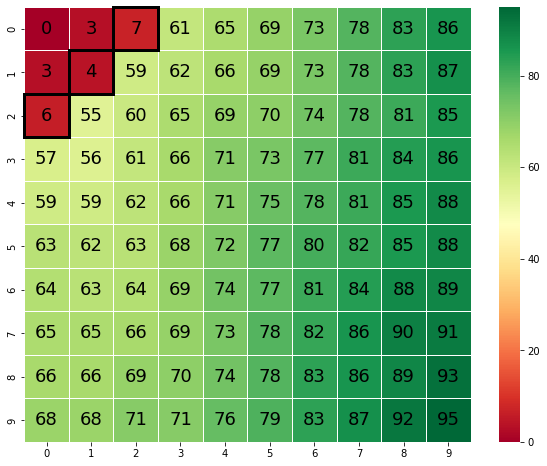

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
sq = int(np.sqrt(n))
tsol = np.reshape(t.x.astype(int), (sq,sq))
f_burned = np.argwhere(z.x)[:,0]
fig, (ax1) = plt.subplots(figsize=(10,8))
sns.heatmap(tsol, linewidth=0.5, annot=True, annot_kws={'size':18, 'color':"black"}, ax=ax1, cmap="RdYlGn")
for idx in f_burned:
    row = idx//sq
    col = idx%sq
    ax1.add_patch(plt.Rectangle((col,row), 1, 1, fc='none', ec='black', lw=3, clip_on=False))

In [ ]:
t.X[2]-t.X[1]+s.x[1,2]

In [ ]:
z.X[ign_node,:,:]

In [ ]:
import networkx as nx
from matplotlib import pyplot as plt
sol = x.X.astype(int)
r = int(np.sqrt(n))
G = nx.from_numpy_array(sol, create_using=nx.DiGraph)
esol = np.argwhere(sol)
for i in range(n):
    nx.set_node_attributes(G, {i:(i%r)}, 'level')
pos = nx.multipartite_layout(G, subset_key="level")
labels = nx.get_edge_attributes(G,'weight')
plt.figure(figsize=(15,15)) 
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_weight="bold")

nx.draw_networkx(G, pos, with_labels=True, node_size=2000, font_weight="bold",font_color="white")
plt.savefig('1.png')
plt.show()



In [ ]:
for v in m2.getVars():
    print(f"{v.VarName} = {v.X}")

In [ ]:
G.nodes[0]